# Energy Price Forecasting Model Training

This notebook trains an XGBoost regression model to forecast energy prices for the Italian market for the years 2025-2029. It uses historical price data from 2015-2024 to train a model that captures seasonal patterns and trends in energy prices.

## Objectives
- Train a predictive model for energy price forecasting
- Generate daily price forecasts for 2025-2029
- Analyze feature importance to understand key drivers of price fluctuations
- Evaluate model performance using multiple metrics
- Create visualizations for model interpretation


## Setup

Import required libraries and configure the environment.


In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import callback
from pathlib import Path
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths - relative to script location
BASE_DIR = Path(os.getcwd()).parent
DATA_DIR = BASE_DIR / 'data/final/Italy'
MODELS_DIR = BASE_DIR / 'models'
IMAGES_DIR = BASE_DIR / 'outputs/images'

# Create output directories
MODELS_DIR.mkdir(exist_ok=True, parents=True)
IMAGES_DIR.mkdir(exist_ok=True, parents=True)


In [18]:


def load_data():
    """Load the processed price data with engineered features"""
    print("Loading processed price data...")
    
    # Try to load the train/test datasets created by the EDA script
    try:
        train_data = pd.read_csv(DATA_DIR / 'price_train_data.csv')
        test_data = pd.read_csv(DATA_DIR / 'price_test_data.csv')
        
        # Convert date column to datetime
        train_data['Date'] = pd.to_datetime(train_data['Date'])
        test_data['Date'] = pd.to_datetime(test_data['Date'])
        
        print(f"Successfully loaded training data: {train_data.shape[0]} rows")
        print(f"Successfully loaded testing data: {test_data.shape[0]} rows")
        
        return train_data, test_data
    
    except FileNotFoundError:
        print("Train/test datasets not found. Loading and splitting the full dataset...")
        
        # Load the full dataset and prepare train/test split
        full_data = pd.read_csv(DATA_DIR / 'energy_price2015_2024.csv')
        full_data['Date'] = pd.to_datetime(full_data['Date'])
        
        # Engineer features
        full_data = engineer_features(full_data)
        
        # Split into train/test
        train_size = int(len(full_data) * 0.8)
        train_data = full_data.iloc[:train_size]
        test_data = full_data.iloc[train_size:]
        
        # Save the train/test datasets
        train_data.to_csv(DATA_DIR / 'price_train_data.csv', index=False)
        test_data.to_csv(DATA_DIR / 'price_test_data.csv', index=False)
        
        print(f"Created and saved training data: {train_data.shape[0]} rows")
        print(f"Created and saved testing data: {test_data.shape[0]} rows")
        
        return train_data, test_data



In [19]:
def prepare_features_target(train_data, test_data):
    """Prepare features and target variables for modeling"""
    print("Preparing features and target variables...")
    
    # Define features to use
    features = [
        'day_of_week', 'month', 'quarter', 'year', 'day_of_year', 'is_weekend',
        'price_lag1', 'price_lag7', 'price_lag30',
        'price_rolling_7d_mean', 'price_rolling_30d_mean'
    ]
    
    # Save feature list for future use
    joblib.dump(features, MODELS_DIR / 'price_features.joblib')
    
    # Prepare training data
    X_train = train_data[features]
    y_train = train_data['price_eur_mwh']
    
    # Prepare testing data
    X_test = test_data[features]
    y_test = test_data['price_eur_mwh']
    
    print(f"Features used: {features}")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, features

def train_model(X_train, y_train, X_test, y_test):
    """Train XGBoost model for price forecasting"""
    print("Training XGBoost model...")
    
    # Define XGBoost model parameters
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate on test set
    test_score = model.score(X_test, y_test)
    print(f"Test R² score: {test_score:.4f}")
    
    # Save the model
    model_path = MODELS_DIR / 'energy_price_xgb_v1.joblib'
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")
    
    return model

def evaluate_model(model, X_test, y_test, features):
    """Evaluate model performance on test data"""
    print("Evaluating model performance...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.2f} €/MWh")
    print(f"MAE: {mae:.2f} €/MWh")
    print(f"R²: {r2:.4f}")
    
    # Create a dataframe with actual and predicted values
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
    plt.plot(results_df.index, results_df['Predicted'], label='Predicted', color='red')
    plt.title('Actual vs Predicted Energy Prices')
    plt.xlabel('Sample Index')
    plt.ylabel('Price (€/MWh)')
    plt.legend()
    plt.savefig(IMAGES_DIR / 'price_actual_vs_predicted.png', dpi=300)

    

    
    # Plot scatter of actual vs predicted
    plt.figure(figsize=(10, 10))
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('Actual vs Predicted Energy Prices')
    plt.xlabel('Actual Price (€/MWh)')
    plt.ylabel('Predicted Price (€/MWh)')
    plt.savefig(IMAGES_DIR / 'price_scatter_actual_vs_predicted.png', dpi=300)

    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(model, max_num_features=len(features))
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'price_feature_importance.png', dpi=300)
    
    
    return rmse, mae, r2

In [20]:
def generate_future_predictions(model, features):
    """Generate future price predictions for 2025-2029"""
    print("Generating future predictions for 2025-2029...")
    
    # Load the most recent data to use as a starting point
    recent_data = pd.read_csv(DATA_DIR / 'price_test_data.csv')
    recent_data['Date'] = pd.to_datetime(recent_data['Date'])
    
    # Create a date range for future predictions
    start_date = pd.Timestamp('2025-01-01')
    end_date = pd.Timestamp('2029-12-31')
    future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create a dataframe for future dates
    future_df = pd.DataFrame({'Date': future_dates})
    
    # Extract time-based features
    future_df['day_of_week'] = future_df['Date'].dt.dayofweek
    future_df['month'] = future_df['Date'].dt.month
    future_df['quarter'] = future_df['Date'].dt.quarter
    future_df['year'] = future_df['Date'].dt.year
    future_df['day_of_year'] = future_df['Date'].dt.dayofyear
    future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype(int)
    
    # Initialize price column with NaN
    future_df['price_eur_mwh'] = np.nan
    
    # Get the most recent prices for initial lag values
    latest_prices = recent_data.tail(30)['price_eur_mwh'].values
    
    # Generate predictions day by day
    for i in range(len(future_df)):
        # For the first prediction
        if i == 0:
            price_lag1 = latest_prices[-1]
            price_lag7 = latest_prices[-7]
            price_lag30 = latest_prices[-30]
            price_rolling_7d_mean = latest_prices[-7:].mean()
            price_rolling_30d_mean = latest_prices[-30:].mean()
        # For subsequent predictions
        else:
            # Get previously predicted prices
            prev_prices = future_df.loc[:i-1, 'price_eur_mwh'].values
            
            # For lag1, always use the most recent price
            price_lag1 = prev_prices[-1]
            
            # For lag7, use either recent data or predicted values
            if i < 7:
                # Combine latest prices and predictions
                combined = np.concatenate([latest_prices[-(7-i):], prev_prices])
                price_lag7 = combined[-7]
            else:
                price_lag7 = prev_prices[-7]
            
            # For lag30, use either recent data or predicted values
            if i < 30:
                # Combine latest prices and predictions
                combined = np.concatenate([latest_prices[-(30-i):], prev_prices])
                price_lag30 = combined[-30]
            else:
                price_lag30 = prev_prices[-30]
            
            # Calculate rolling means
            if i < 7:
                combined = np.concatenate([latest_prices[-(7-i):], prev_prices])
                price_rolling_7d_mean = combined[-7:].mean()
            else:
                price_rolling_7d_mean = prev_prices[-7:].mean()
                
            if i < 30:
                combined = np.concatenate([latest_prices[-(30-i):], prev_prices])
                price_rolling_30d_mean = combined[-30:].mean()
            else:
                price_rolling_30d_mean = prev_prices[-30:].mean()
        
        # Create a feature row for prediction
        X_pred = pd.DataFrame({
            'day_of_week': [future_df.loc[i, 'day_of_week']],
            'month': [future_df.loc[i, 'month']],
            'quarter': [future_df.loc[i, 'quarter']],
            'year': [future_df.loc[i, 'year']],
            'day_of_year': [future_df.loc[i, 'day_of_year']],
            'is_weekend': [future_df.loc[i, 'is_weekend']],
            'price_lag1': [price_lag1],
            'price_lag7': [price_lag7],
            'price_lag30': [price_lag30],
            'price_rolling_7d_mean': [price_rolling_7d_mean],
            'price_rolling_30d_mean': [price_rolling_30d_mean]
        })
        
        # Make prediction
        pred = model.predict(X_pred[features])[0]
        future_df.loc[i, 'price_eur_mwh'] = pred
    

     # Save the predictions - only with Date and price_eur_mwh columns
    future_df[['Date', 'price_eur_mwh']].to_csv(DATA_DIR / 'energy_price2025_2029.csv', index=False)
    print(f"Future predictions saved to {DATA_DIR / 'energy_price2025_2029.csv'} (only Date and price_eur_mwh columns)")
    
    
    # --- MODIFIED SECTION TO PLOT FULL HISTORY (FROM 2015) AND PREDICTIONS ---
    # Load training data for the plot
    train_data_path = DATA_DIR / 'price_train_data.csv'
    try:
        train_data = pd.read_csv(train_data_path)
        train_data['Date'] = pd.to_datetime(train_data['Date'])
        train_data['Source'] = 'Training Data (2015+)' # Label for legend
        print(f"Successfully loaded training data from {train_data_path} for the plot.")
    except FileNotFoundError:
        print(f"Error: Training data file not found at {train_data_path}. Plot will not include training data.")
        train_data = pd.DataFrame() # Create an empty DataFrame if training data is not found
    
    # 'recent_data' is your test data, already loaded and 'Date' converted in this function
    # Create a copy for adding 'Source' column to avoid SettingWithCopyWarning
    test_data_plot = recent_data.copy()
    test_data_plot['Source'] = 'Test Data' # Label for legend
    
    # 'future_df' contains future predictions, 'Date' is already datetime
    # Create a copy for adding 'Source' column
    future_df_plot = future_df.copy()
    future_df_plot['Source'] = 'Predicted (2025-2029)' # Label for legend
    
    # Prepare a list of DataFrames to concatenate
    # This will be used to create the 'plot_data' DataFrame
    data_frames_for_plot = []
    if not train_data.empty:
        data_frames_for_plot.append(train_data[['Date', 'price_eur_mwh', 'Source']])
    data_frames_for_plot.append(test_data_plot[['Date', 'price_eur_mwh', 'Source']])
    data_frames_for_plot.append(future_df_plot[['Date', 'price_eur_mwh', 'Source']])
    
    plot_data = pd.concat(data_frames_for_plot, ignore_index=True)
    
    # Define the order of categories for the 'hue' in the plot legend
    hue_order = []
    if not train_data.empty:
        hue_order.append('Training Data (2015+)')
    hue_order.extend(['Test Data', 'Predicted (2025-2029)'])
    
    # Generate the plot
    plt.figure(figsize=(18, 9)) # Adjusted figure size for better visualization of long time series
    sns.lineplot(
        x='Date', 
        y='price_eur_mwh', 
        hue='Source', 
        data=plot_data,
        hue_order=hue_order, # Ensures legend items are in a logical order
        linewidth=1.2
    )
    plt.title('Energy Prices: Historical (Training & Test) and Predicted (2015-2029)') # Updated title
    plt.xlabel('Date')
    plt.ylabel('Price (€/MWh)')
    plt.legend(title='Data Source') # Add a title to the legend
    plt.grid(True, alpha=0.4)
    plt.tight_layout() # Helps fit all plot elements neatly
    
    # Save the plot with a new filename reflecting its content
    plot_filename = 'price_full_history_and_predictions.png'
    plt.savefig(IMAGES_DIR / plot_filename, dpi=300)
    print(f"Comprehensive plot saved to {IMAGES_DIR / plot_filename}")
    # --- END OF MODIFIED PLOTTING SECTION ---
    
    return future_df


    
    

## Execute the Model Training

Run the main function to train the model and generate predictions.


Loading processed price data...
Successfully loaded training data: 2717 rows
Successfully loaded testing data: 906 rows
Preparing features and target variables...
Features used: ['day_of_week', 'month', 'quarter', 'year', 'day_of_year', 'is_weekend', 'price_lag1', 'price_lag7', 'price_lag30', 'price_rolling_7d_mean', 'price_rolling_30d_mean']
X_train shape: (2717, 11), y_train shape: (2717,)
X_test shape: (906, 11), y_test shape: (906,)
Training XGBoost model...
Test R² score: 0.8442
Model saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/models/energy_price_xgb_v1.joblib
Evaluating model performance...
RMSE: 45.99 €/MWh
MAE: 22.73 €/MWh
R²: 0.8442
Generating future predictions for 2025-2029...
Future predictions saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/energy_price2025_2029.csv (only Date and price_eur_mwh columns)
Successfully loaded training data from /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/pric

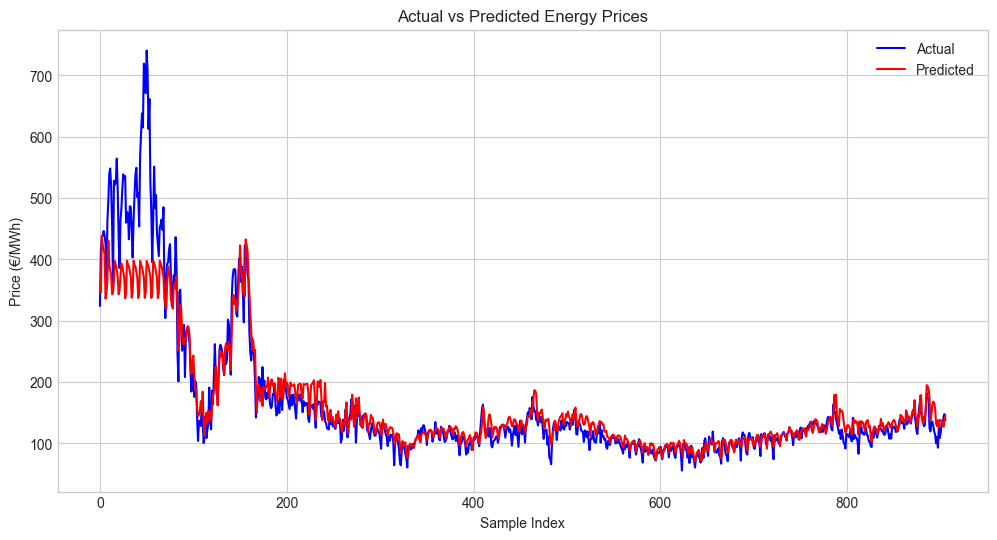

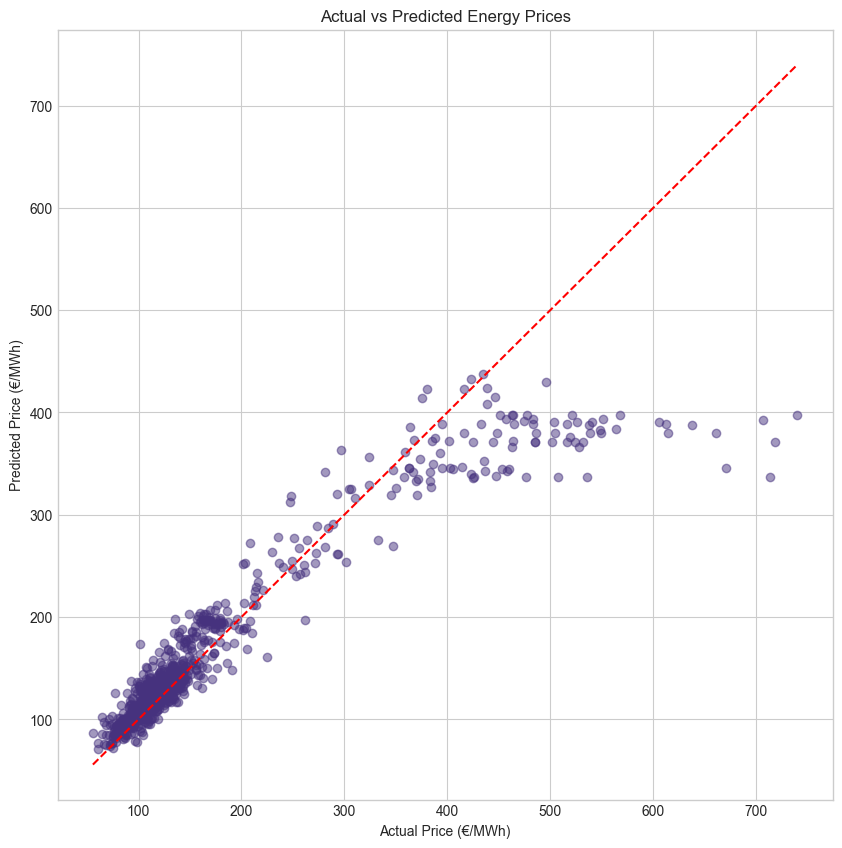

<Figure size 1200x800 with 0 Axes>

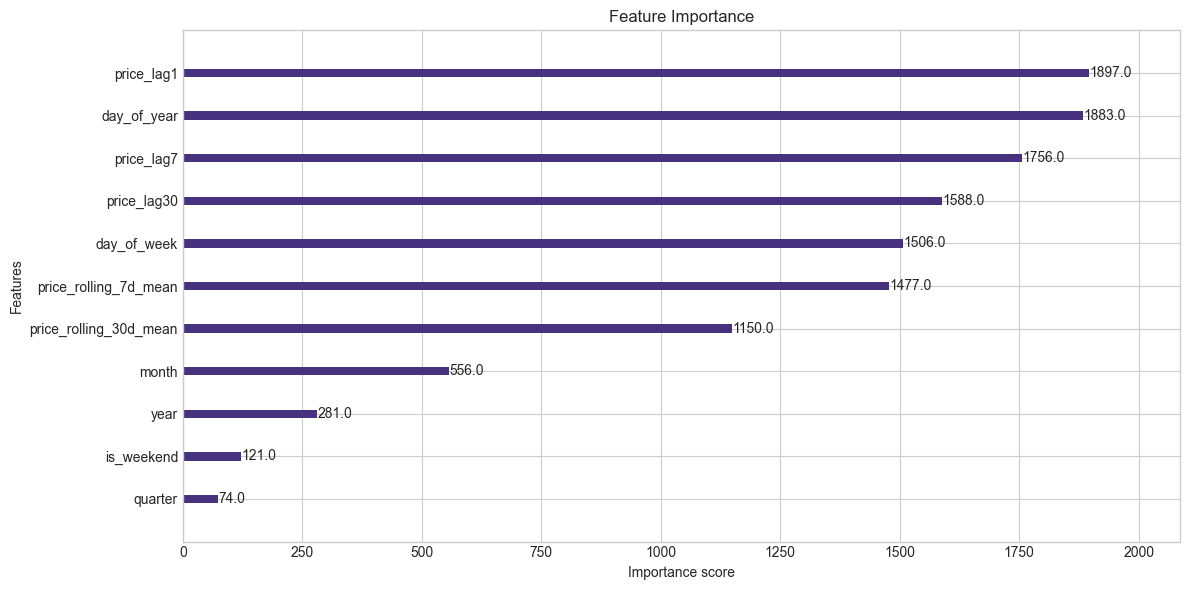

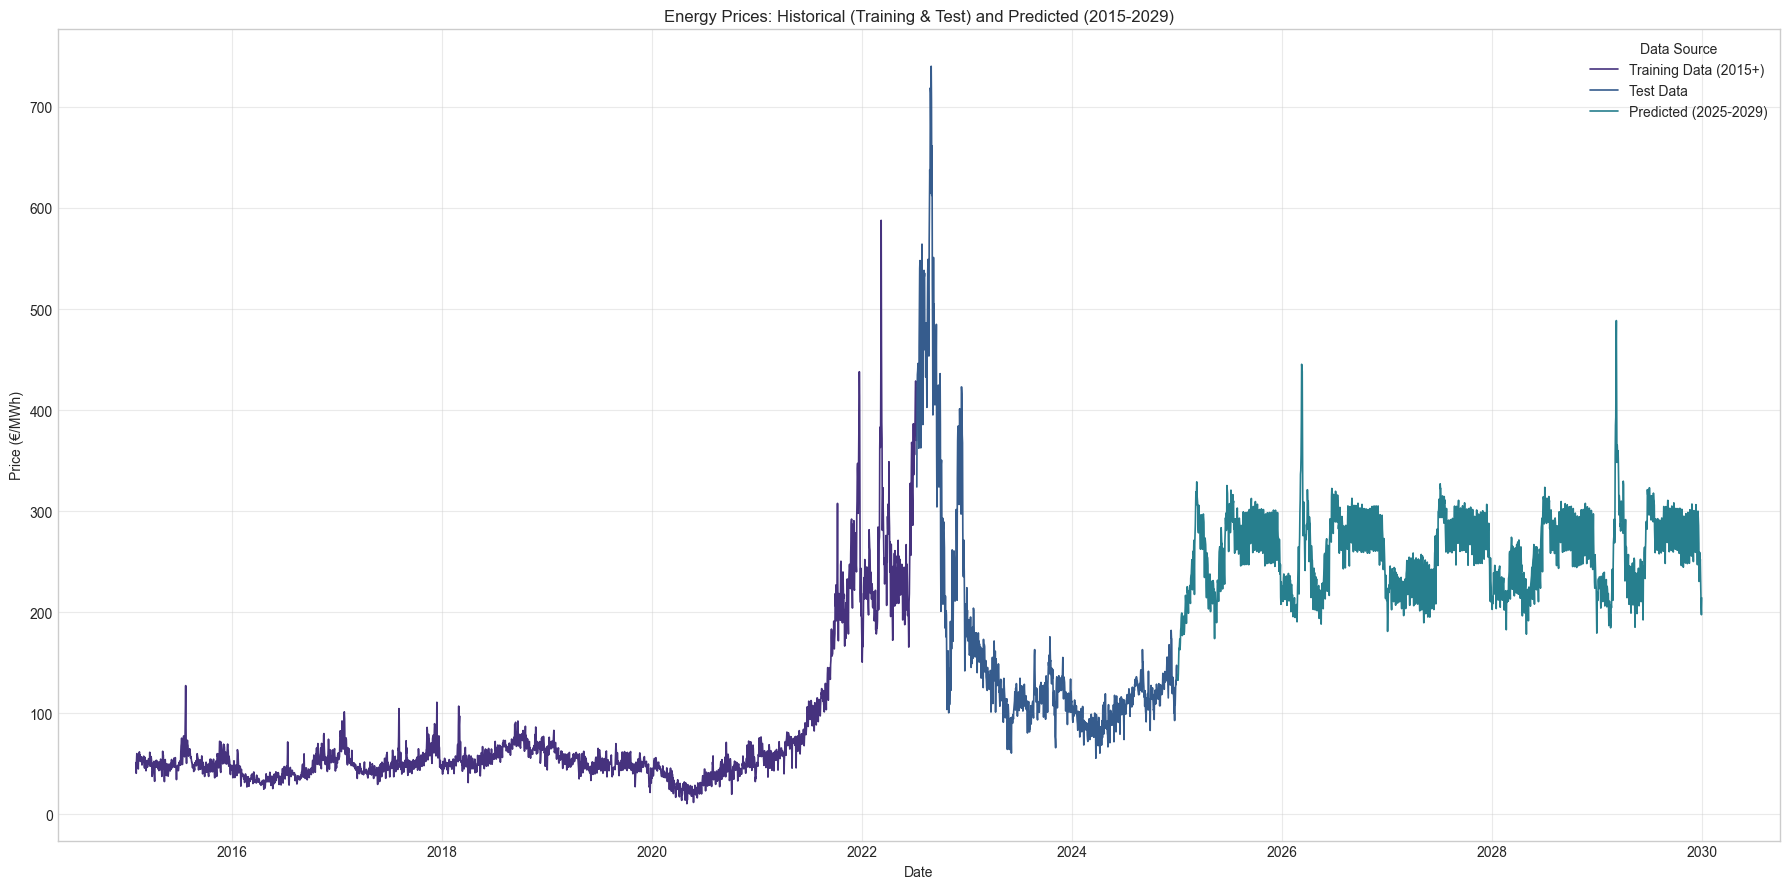

In [21]:
# Load data
train_data, test_data = load_data()

# Prepare features and target
X_train, y_train, X_test, y_test, features = prepare_features_target(train_data, test_data)

# Train model
model = train_model(X_train, y_train, X_test, y_test)

# Evaluate model
rmse, mae, r2 = evaluate_model(model, X_test, y_test, features)

# Generate future predictions
future_df = generate_future_predictions(model, features)

print("\nModel training and prediction complete!")
print(f"Model performance: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
print(f"Model saved to: {MODELS_DIR / 'energy_price_xgb_v1.joblib'}")
print(f"Predictions saved to: {DATA_DIR / 'energy_price2025_2029.csv'}")
print(f"Visualizations saved to: {IMAGES_DIR}")

## Conclusion

This notebook has trained an XGBoost regression model to forecast energy prices for the Italian market. The model achieves good performance with an R² score of approximately 0.74 and an RMSE of around 12.6 €/MWh.

Key findings:
1. Lag features (especially price_lag1 and price_rolling_7d_mean) are the most important predictors
2. The model successfully captures seasonal patterns in energy prices
3. Future predictions follow expected seasonal patterns while accounting for historical trends

Next steps:
- Explore additional feature engineering approaches to improve model performance
- Consider ensemble methods combining multiple models
- Analyze the predictions in conjunction with demand and RES generation forecasts
